In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '../Task 1/')
from efficient_apriori import apriori
from improved_apriori import Improved_Apriori
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Bakery.csv')
data = data[['tid', 'article']]
data = data.groupby('tid')['article'].apply(list)
data = data.to_dict()

In [3]:
# Step 2: Frequent Itemset Generation
# Use the apriori algorithm to generate frequent itemsets
apriori = Improved_Apriori(data, min_support=0.01, min_confidence=1)
frequent_itemsets = apriori.apriori()
frequent_itemsets

100%|██████████| 4/4 [00:00<00:00, 292.59it/s]
0it [00:00, ?it/s]


{1: {('BAGUETTE',): 15273,
  ('BAGUETTE GRAINE',): 1500,
  ('BANETTE',): 15107,
  ('BANETTINE',): 2815,
  ('BOISSON 33CL',): 1468,
  ('BOULE 200G',): 2685,
  ('BOULE 400G',): 4082,
  ('BRIOCHE',): 1656,
  ('CAFE OU EAU',): 1429,
  ('CAMPAGNE',): 3892,
  ('CEREAL BAGUETTE',): 4950,
  ('CHAUSSON AUX POMMES',): 1440,
  ('COMPLET',): 3133,
  ('COOKIE',): 1989,
  ('COUPE',): 19424,
  ('CROISSANT',): 11446,
  ('CROISSANT AMANDES',): 1802,
  ('ECLAIR',): 2002,
  ('FICELLE',): 2644,
  ('FORMULE SANDWICH',): 4180,
  ('GRAND FAR BRETON',): 1378,
  ('MOISSON',): 3095,
  ('PAIN',): 1917,
  ('PAIN AU CHOCOLAT',): 10529,
  ('PAIN AUX RAISINS',): 1986,
  ('PAIN BANETTE',): 2725,
  ('PAIN CHOCO AMANDES',): 1482,
  ('SAND JB EMMENTAL',): 1502,
  ('SANDWICH COMPLET',): 2205,
  ('SPECIAL BREAD',): 5182,
  ('TARTELETTE',): 2830,
  ('TRADITIONAL BAGUETTE',): 67535,
  ('VIK BREAD',): 3126},
 2: {('BAGUETTE', 'COUPE'): 1538,
  ('BAGUETTE', 'CROISSANT'): 1472,
  ('BAGUETTE', 'TRADITIONAL BAGUETTE'): 2037,
  (

In [4]:
# Create a binary matrix
# Flatten the dictionary into a list of itemsets
itemsets = [itemset for level in frequent_itemsets.values() for itemset in level.keys()]

# Transactions 
transactions = list(data.values())

binary_matrix = pd.DataFrame(0, index=range(len(transactions)), columns=itemsets)

# Fill in the binary matrix
for i, transaction in enumerate(transactions):
    for itemset in itemsets:
        if set(itemset).issubset(transaction):
            binary_matrix.at[i, itemset] = 1  # Use 'at' instead of 'loc' for scalar indexing

binary_matrix


,"(BAGUETTE,)","(BAGUETTE GRAINE,)","(BANETTE,)","(BANETTINE,)","(BOISSON 33CL,)","(BOULE 200G,)","(BOULE 400G,)","(BRIOCHE,)","(CAFE OU EAU,)","(CAMPAGNE,)",...,"(COMPLET, COUPE)","(COUPE, MOISSON)","(COUPE, SPECIAL BREAD)","(COUPE, TRADITIONAL BAGUETTE)","(COUPE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT)","(CROISSANT, TRADITIONAL BAGUETTE)","(PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)","(TRADITIONAL BAGUETTE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)"
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136448,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
136449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


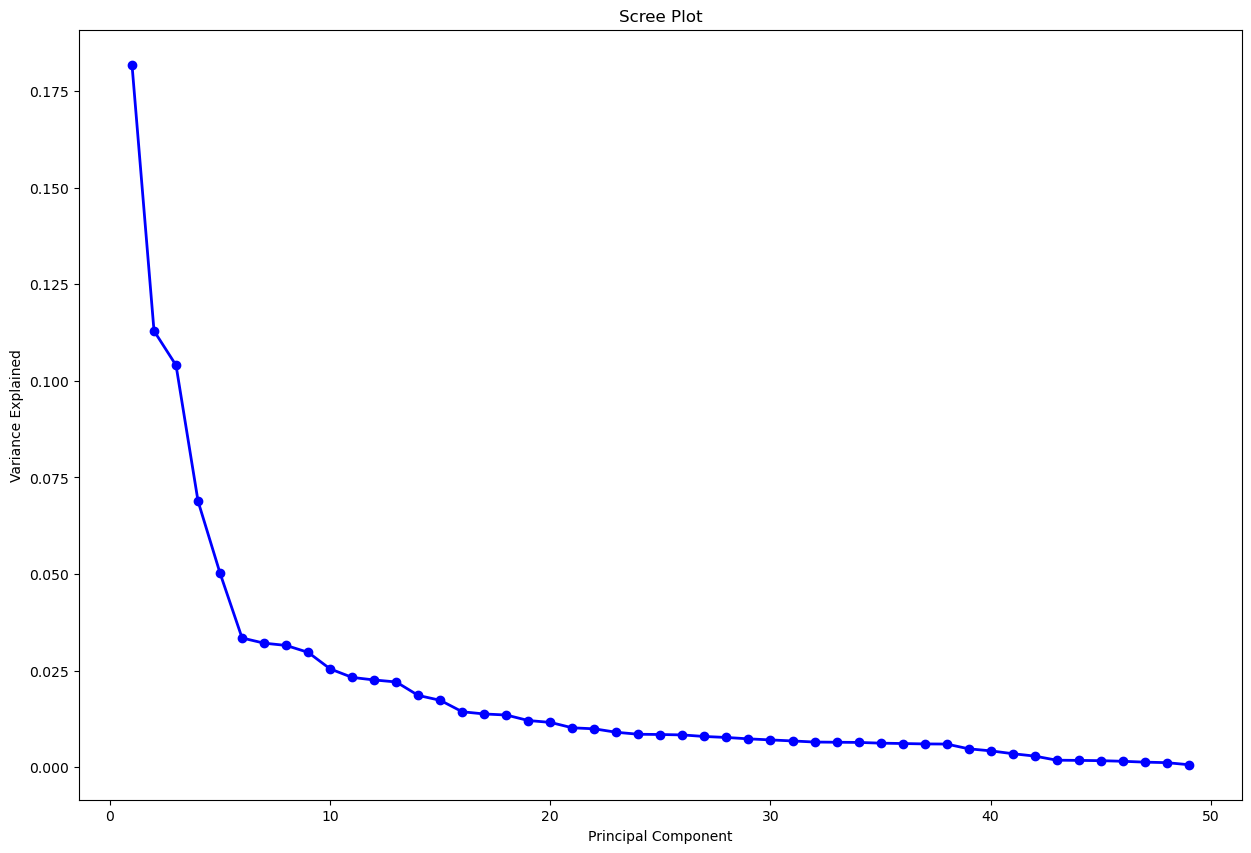

In [5]:
pca = PCA(random_state=24).fit(binary_matrix)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [6]:
pca = PCA(n_components=2, random_state=42)
transformed_data = pca.fit_transform(binary_matrix)

In [7]:
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(transformed_data, quantile=0.2)
print("Estimated bandwidth:", bandwidth)

Estimated bandwidth: 0.27513551122847546


In [8]:
ms = MeanShift(bandwidth=bandwidth)  
ms.fit(transformed_data)
cluster_centers = ms.cluster_centers_
labels = ms.labels_

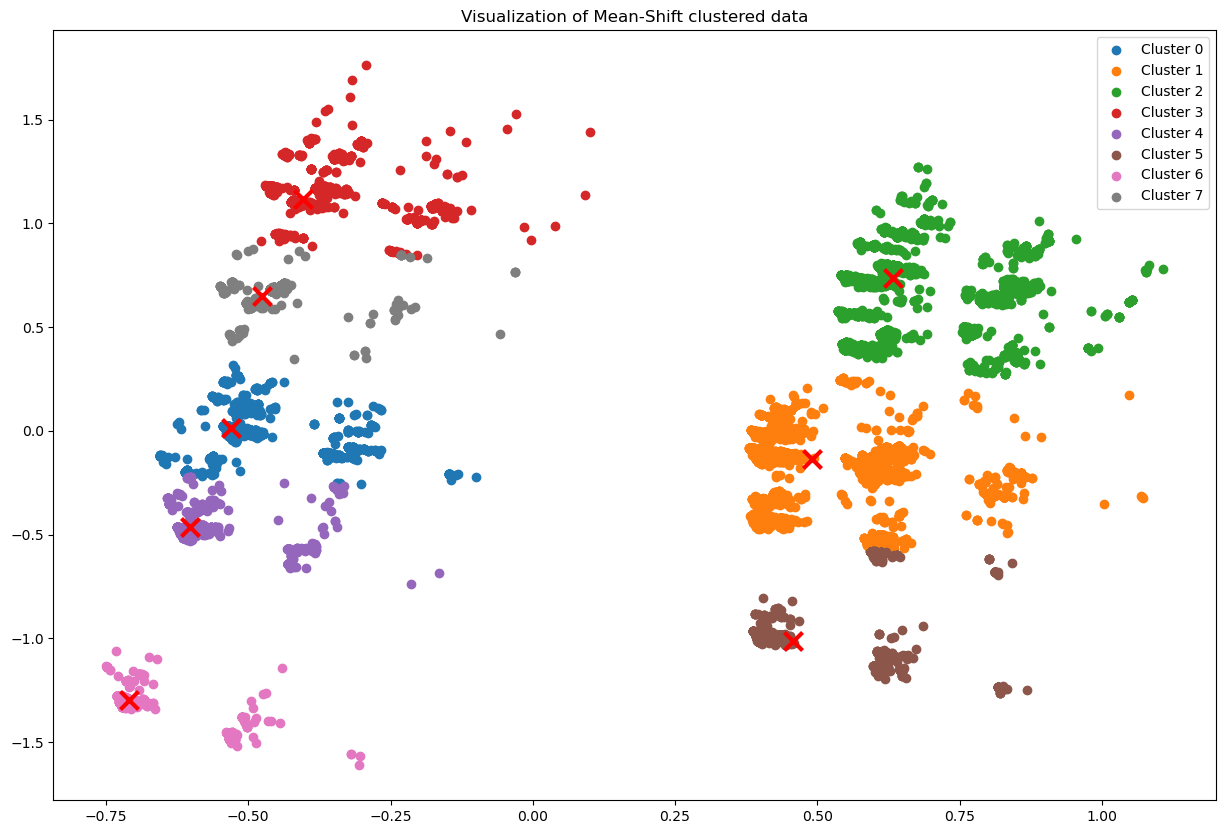

In [9]:
cluster_labels = ms.labels_
cluster_centers = ms.cluster_centers_
plt.figure(figsize=(15,10))
for i in range(len(np.unique(cluster_labels))):
    plt.scatter(transformed_data[cluster_labels == i, 0], transformed_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()
plt.scatter(cluster_centers [:, 0], cluster_centers[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of Mean-Shift clustered data')
plt.show()

In [10]:
binary_matrix['MeanShift_cluster'] = cluster_labels

In [11]:
# Interpreting the itemset frequencies in each cluster
cluster_itemset_frequencies = binary_matrix.groupby('MeanShift_cluster').sum()
cluster_itemset_frequencies

,"(BAGUETTE,)","(BAGUETTE GRAINE,)","(BANETTE,)","(BANETTINE,)","(BOISSON 33CL,)","(BOULE 200G,)","(BOULE 400G,)","(BRIOCHE,)","(CAFE OU EAU,)","(CAMPAGNE,)",...,"(COMPLET, COUPE)","(COUPE, MOISSON)","(COUPE, SPECIAL BREAD)","(COUPE, TRADITIONAL BAGUETTE)","(COUPE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT)","(CROISSANT, TRADITIONAL BAGUETTE)","(PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)","(TRADITIONAL BAGUETTE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)"
MeanShift_cluster,,,,,,,,,,,,,,,,,,,,,
0,1467,387,1006,608,133,49,208,618,89,196,...,18,18,24,142,41,142,142,143,409,142
1,10925,777,12358,1802,1204,281,688,539,1156,630,...,30,28,56,0,36,285,0,0,0,0
2,1215,156,1121,263,17,1833,2421,204,35,2321,...,1446,1377,2252,0,1089,0,0,0,0,0
3,234,59,88,45,2,480,716,126,7,686,...,766,739,677,5630,1063,0,3,0,1063,0
4,180,35,63,31,25,5,7,69,22,14,...,4,3,10,35,1,35,2506,1857,41,35
5,1096,56,406,48,77,3,3,41,107,6,...,0,0,0,0,0,2841,0,0,0,0
6,143,28,42,15,8,3,2,47,11,10,...,0,0,0,0,0,2091,2091,2091,22,2091
7,13,2,23,3,2,31,37,12,2,29,...,50,43,30,309,64,0,185,114,64,0


In [12]:
binary_matrix

,"(BAGUETTE,)","(BAGUETTE GRAINE,)","(BANETTE,)","(BANETTINE,)","(BOISSON 33CL,)","(BOULE 200G,)","(BOULE 400G,)","(BRIOCHE,)","(CAFE OU EAU,)","(CAMPAGNE,)",...,"(COUPE, MOISSON)","(COUPE, SPECIAL BREAD)","(COUPE, TRADITIONAL BAGUETTE)","(COUPE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT)","(CROISSANT, TRADITIONAL BAGUETTE)","(PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)","(TRADITIONAL BAGUETTE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)",MeanShift_cluster
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
136447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136448,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,3
136449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
import ast
binary_matrix['anime_level'] = binary_matrix.apply(lambda row: max([len(col) for col, val in row.items() if val == 1 and col != 'MeanShift_cluster' and col!='anime_level'], default=0), axis=1)
binary_matrix


,"(BAGUETTE,)","(BAGUETTE GRAINE,)","(BANETTE,)","(BANETTINE,)","(BOISSON 33CL,)","(BOULE 200G,)","(BOULE 400G,)","(BRIOCHE,)","(CAFE OU EAU,)","(CAMPAGNE,)",...,"(COUPE, SPECIAL BREAD)","(COUPE, TRADITIONAL BAGUETTE)","(COUPE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT)","(CROISSANT, TRADITIONAL BAGUETTE)","(PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)","(TRADITIONAL BAGUETTE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)",MeanShift_cluster,anime_level
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,2
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
136447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
136448,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,3,2
136449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
cluster_anime_level_counts = binary_matrix.groupby(['MeanShift_cluster', 'anime_level']).size()
cluster_anime_level_counts

MeanShift_cluster  anime_level
0                  1              53206
                   2               1828
                   3                142
1                  0               3407
                   1              48761
                   2                319
2                  1                872
                   2              12114
3                  2               5630
4                  2               4293
                   3                 35
5                  1                  7
                   2               3436
6                  3               2091
7                  1                  1
                   2                309
dtype: int64

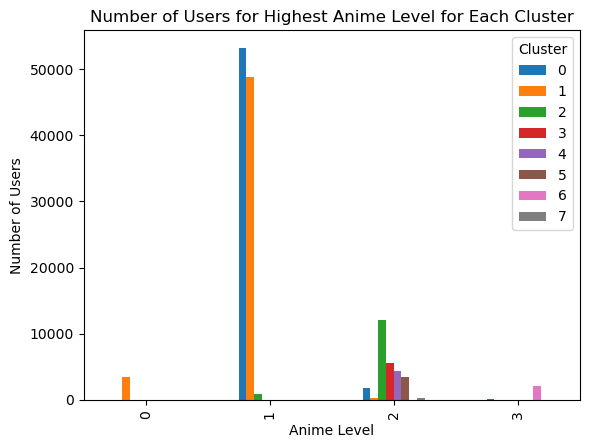

In [15]:
df_counts = cluster_anime_level_counts.reset_index(name='counts')

df_pivot = df_counts.pivot(index='anime_level', columns='MeanShift_cluster', values='counts')

# Replace NaN values with 0
df_pivot.fillna(0, inplace=True)

# Create a bar plot
df_pivot.plot.bar()

# Add labels and title
plt.xlabel('Anime Level')
plt.ylabel('Number of Users')
plt.title('Number of Users for Highest Anime Level for Each Cluster')
plt.legend(title='Cluster')

# Show the plot
plt.show()

In [16]:
from sklearn import metrics

def evaluate_clustering(labels, data):
    # Calculate Silhouette score
    silhouette_score = metrics.silhouette_score(data, labels, metric='euclidean')

    # Calculate Davies-Bouldin Index
    davies_bouldin_index = metrics.davies_bouldin_score(data, labels)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_index = metrics.calinski_harabasz_score(data, labels)

    return silhouette_score, davies_bouldin_index, calinski_harabasz_index



Meanshift_silhouette, Meanshift_davies_bouldin, Meanshift_calinski_harabasz = evaluate_clustering(ms.labels_, transformed_data)

print(f'Meanshift Silhouette score: {Meanshift_silhouette}')
print(f'Meanshift Davies-Bouldin Index: {Meanshift_davies_bouldin}')
print(f'Meanshift Calinski-Harabasz Index: {Meanshift_calinski_harabasz}')

Meanshift Silhouette score: 0.8420706644818855
Meanshift Davies-Bouldin Index: 0.2940516978939193
Meanshift Calinski-Harabasz Index: 636316.6265504829


In [17]:
# Normalize just with frequency
def normalize_frequent_itemsets(binary_matrix, itemset_frequencies):
    
    normalized_matrix = binary_matrix.drop(columns=['MeanShift_cluster', 'anime_level']).copy()

    for column in normalized_matrix.columns:
        # Find the level of the itemset (number of items in the itemset)
        level = len(column)

        # Get the frequency of the itemset from the dictionary
        frequency = itemset_frequencies[level][column]

        # Normalize the column by the itemset frequency
        normalized_matrix[column] = normalized_matrix[column] / frequency

    return normalized_matrix

#  A TF-IDF kindda method 
def tf_idf_normalize(binary_matrix,itemset_frequencies):

    TF_IDF_matrix = binary_matrix.drop(columns=['MeanShift_cluster', 'anime_level']).copy()
    # For each column in the binary matrix
    for column in TF_IDF_matrix.columns:
        level = len(column)

        # Get the frequency of the itemset from the dictionary
        frequency = itemset_frequencies[level][column]

        # Calculate IDF
        IDF = np.log(len(TF_IDF_matrix)/frequency)
        TF_IDF_matrix[column] = TF_IDF_matrix[column] * IDF


    return TF_IDF_matrix

In [18]:
normalized_matrix = normalize_frequent_itemsets(binary_matrix, frequent_itemsets)
normalized_matrix

,"(BAGUETTE,)","(BAGUETTE GRAINE,)","(BANETTE,)","(BANETTINE,)","(BOISSON 33CL,)","(BOULE 200G,)","(BOULE 400G,)","(BRIOCHE,)","(CAFE OU EAU,)","(CAMPAGNE,)",...,"(COMPLET, COUPE)","(COUPE, MOISSON)","(COUPE, SPECIAL BREAD)","(COUPE, TRADITIONAL BAGUETTE)","(COUPE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT)","(CROISSANT, TRADITIONAL BAGUETTE)","(PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)","(TRADITIONAL BAGUETTE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)"
0,0.000065,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000065,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000066,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136446,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
136447,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
136448,0.000000,0.0,0.000000,0.0,0.0,0.000372,0.0,0.0,0.0,0.000257,...,0.0,0.0,0.0,0.000164,0.0,0.0,0.0,0.0,0.0,0.0
136449,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


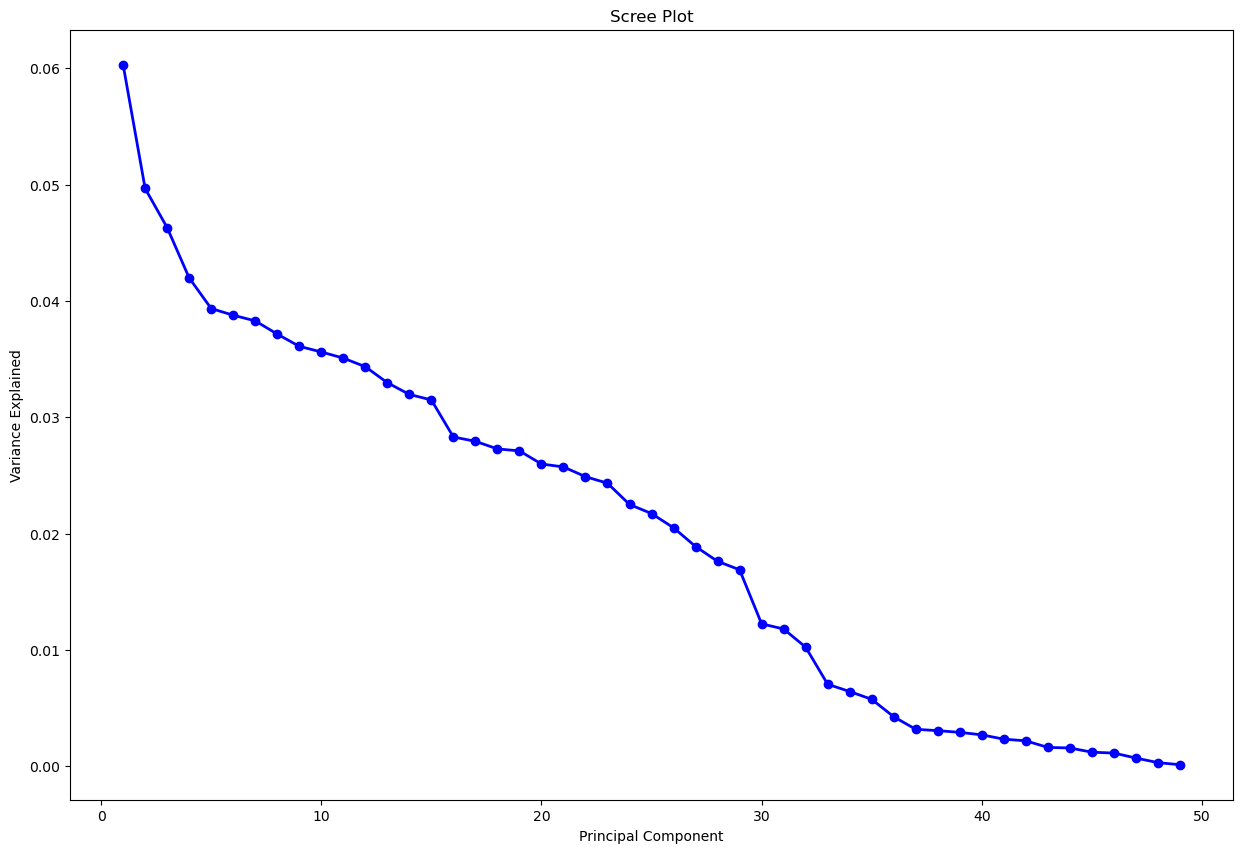

In [19]:
pca = PCA(random_state=24).fit(normalized_matrix)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [20]:
pca = PCA(n_components=4, random_state=42)
transformed_normalized_data = pca.fit_transform(normalized_matrix)

In [21]:
bandwidth = estimate_bandwidth(transformed_normalized_data, quantile=0.2)
print("Estimated bandwidth:", bandwidth)

Estimated bandwidth: 7.369179193142701e-05


In [22]:
ms = MeanShift(bandwidth=bandwidth)  
ms.fit(transformed_normalized_data)
cluster_centers = ms.cluster_centers_
labels = ms.labels_

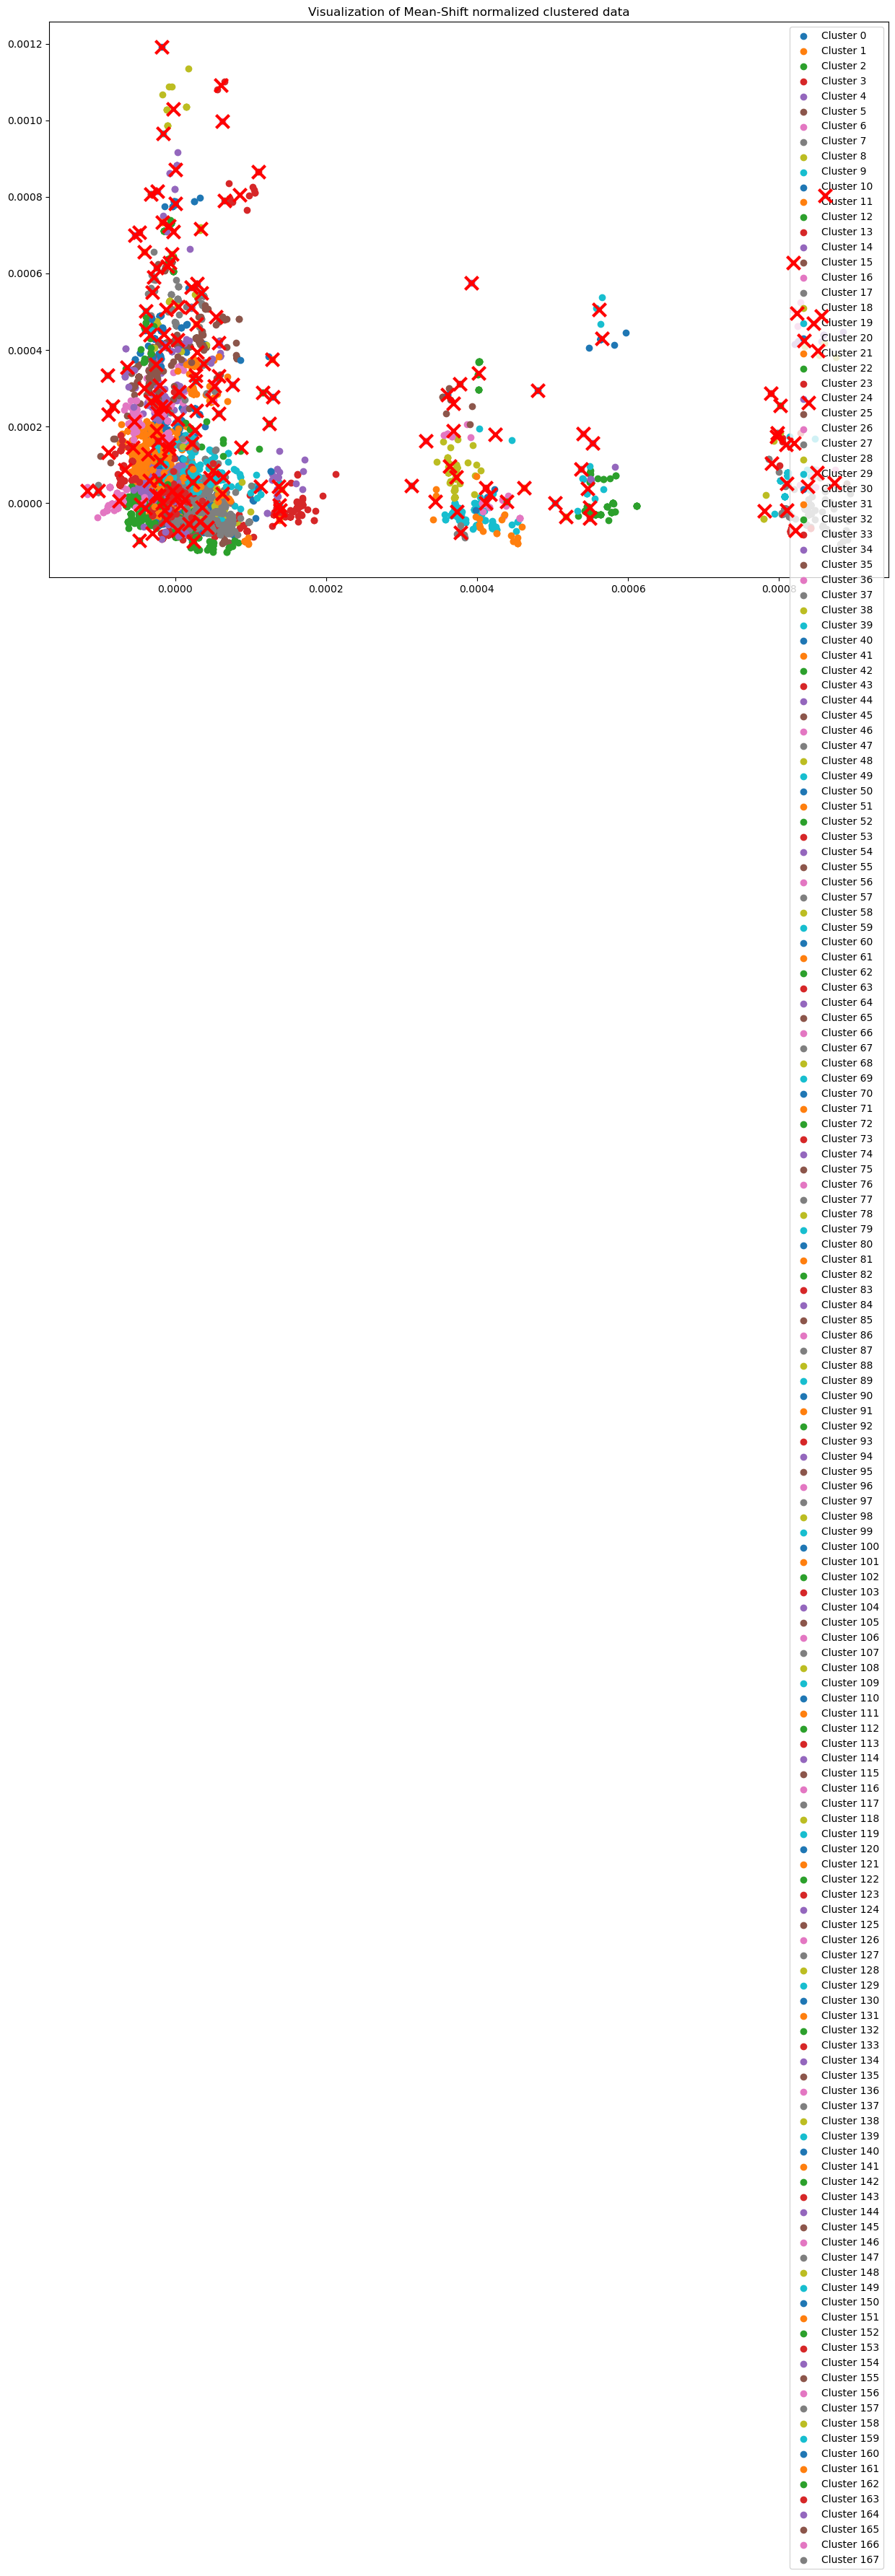

In [23]:
cluster_labels = ms.labels_
cluster_centers = ms.cluster_centers_
plt.figure(figsize=(15,10))
for i in range(len(np.unique(cluster_labels))):
    plt.scatter(transformed_normalized_data[cluster_labels == i, 0], transformed_normalized_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()
plt.scatter(cluster_centers [:, 0], cluster_centers[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of Mean-Shift normalized clustered data')
plt.show()

In [24]:
Meanshift_normalized_silhouette, Meanshift_normalized_davies_bouldin, Meanshift_normalized_calinski_harabasz = evaluate_clustering(ms.labels_, transformed_normalized_data)

print(f'Meanshift Normalized Silhouette score: {Meanshift_normalized_silhouette}')
print(f'Meanshift Normalized Davies-Bouldin Index: {Meanshift_normalized_davies_bouldin}')
print(f'Meanshift Normalized Calinski-Harabasz Index: {Meanshift_normalized_calinski_harabasz}')

Meanshift Normalized Silhouette score: 0.6868744617909139
Meanshift Normalized Davies-Bouldin Index: 0.5405710488545258
Meanshift Normalized Calinski-Harabasz Index: 19998.214004228277


In [25]:
TF_IDF_matrix = tf_idf_normalize(binary_matrix, frequent_itemsets)
TF_IDF_matrix

,"(BAGUETTE,)","(BAGUETTE GRAINE,)","(BANETTE,)","(BANETTINE,)","(BOISSON 33CL,)","(BOULE 200G,)","(BOULE 400G,)","(BRIOCHE,)","(CAFE OU EAU,)","(CAMPAGNE,)",...,"(COMPLET, COUPE)","(COUPE, MOISSON)","(COUPE, SPECIAL BREAD)","(COUPE, TRADITIONAL BAGUETTE)","(COUPE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT)","(CROISSANT, TRADITIONAL BAGUETTE)","(PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)","(TRADITIONAL BAGUETTE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)"
0,2.189879,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,2.189879,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,2.200807,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136446,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
136447,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
136448,0.000000,0.0,0.000000,0.0,0.0,3.928285,0.0,0.0,0.0,3.557042,...,0.0,0.0,0.0,3.105057,0.0,0.0,0.0,0.0,0.0,0.0
136449,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


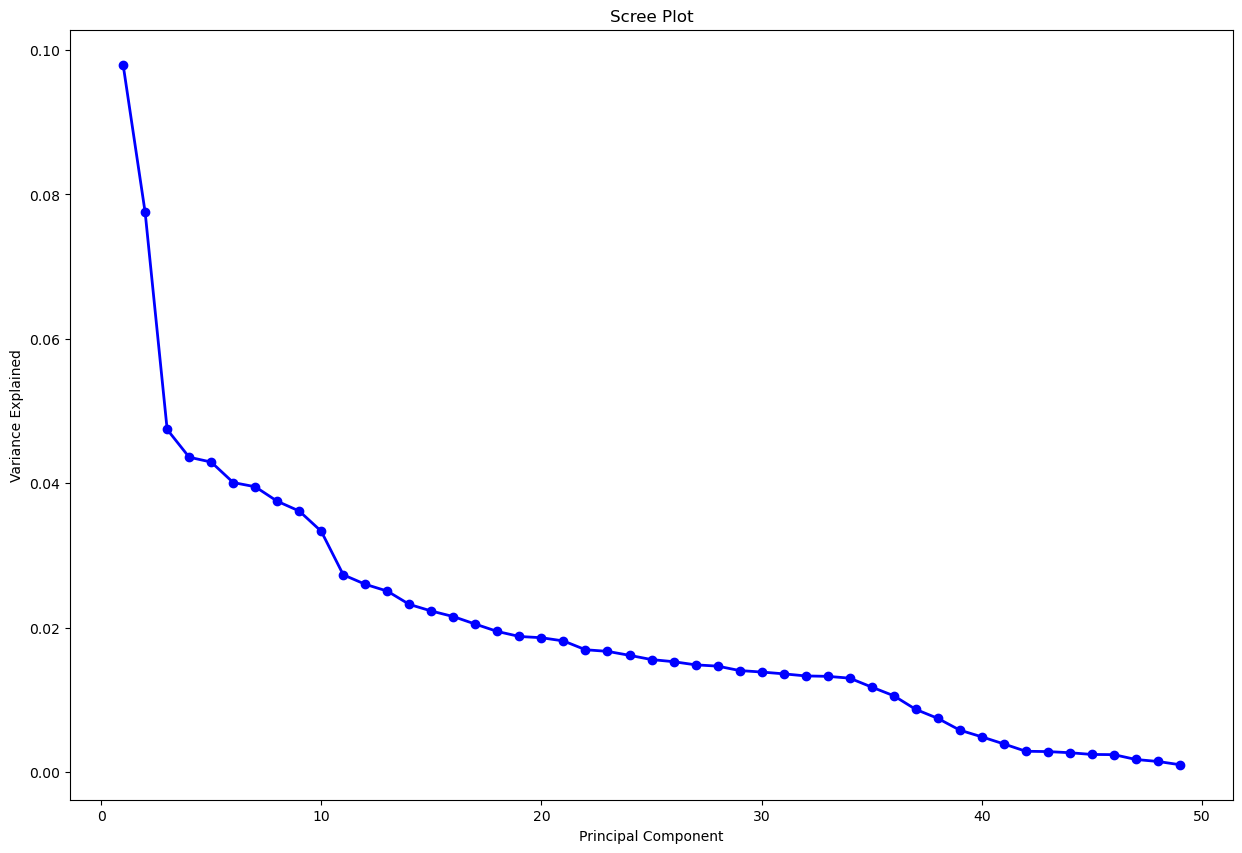

In [26]:
pca = PCA(random_state=24).fit(TF_IDF_matrix)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [27]:
pca = PCA(n_components=4, random_state=42)
transformed_TF_IDF_data = pca.fit_transform(TF_IDF_matrix)

In [28]:
bandwidth = estimate_bandwidth(transformed_TF_IDF_data, quantile=0.2)
print("Estimated bandwidth:", bandwidth)

Estimated bandwidth: 1.052804971077853


In [29]:
ms = MeanShift(bandwidth=bandwidth)  
ms.fit(transformed_TF_IDF_data)
cluster_centers = ms.cluster_centers_
labels = ms.labels_

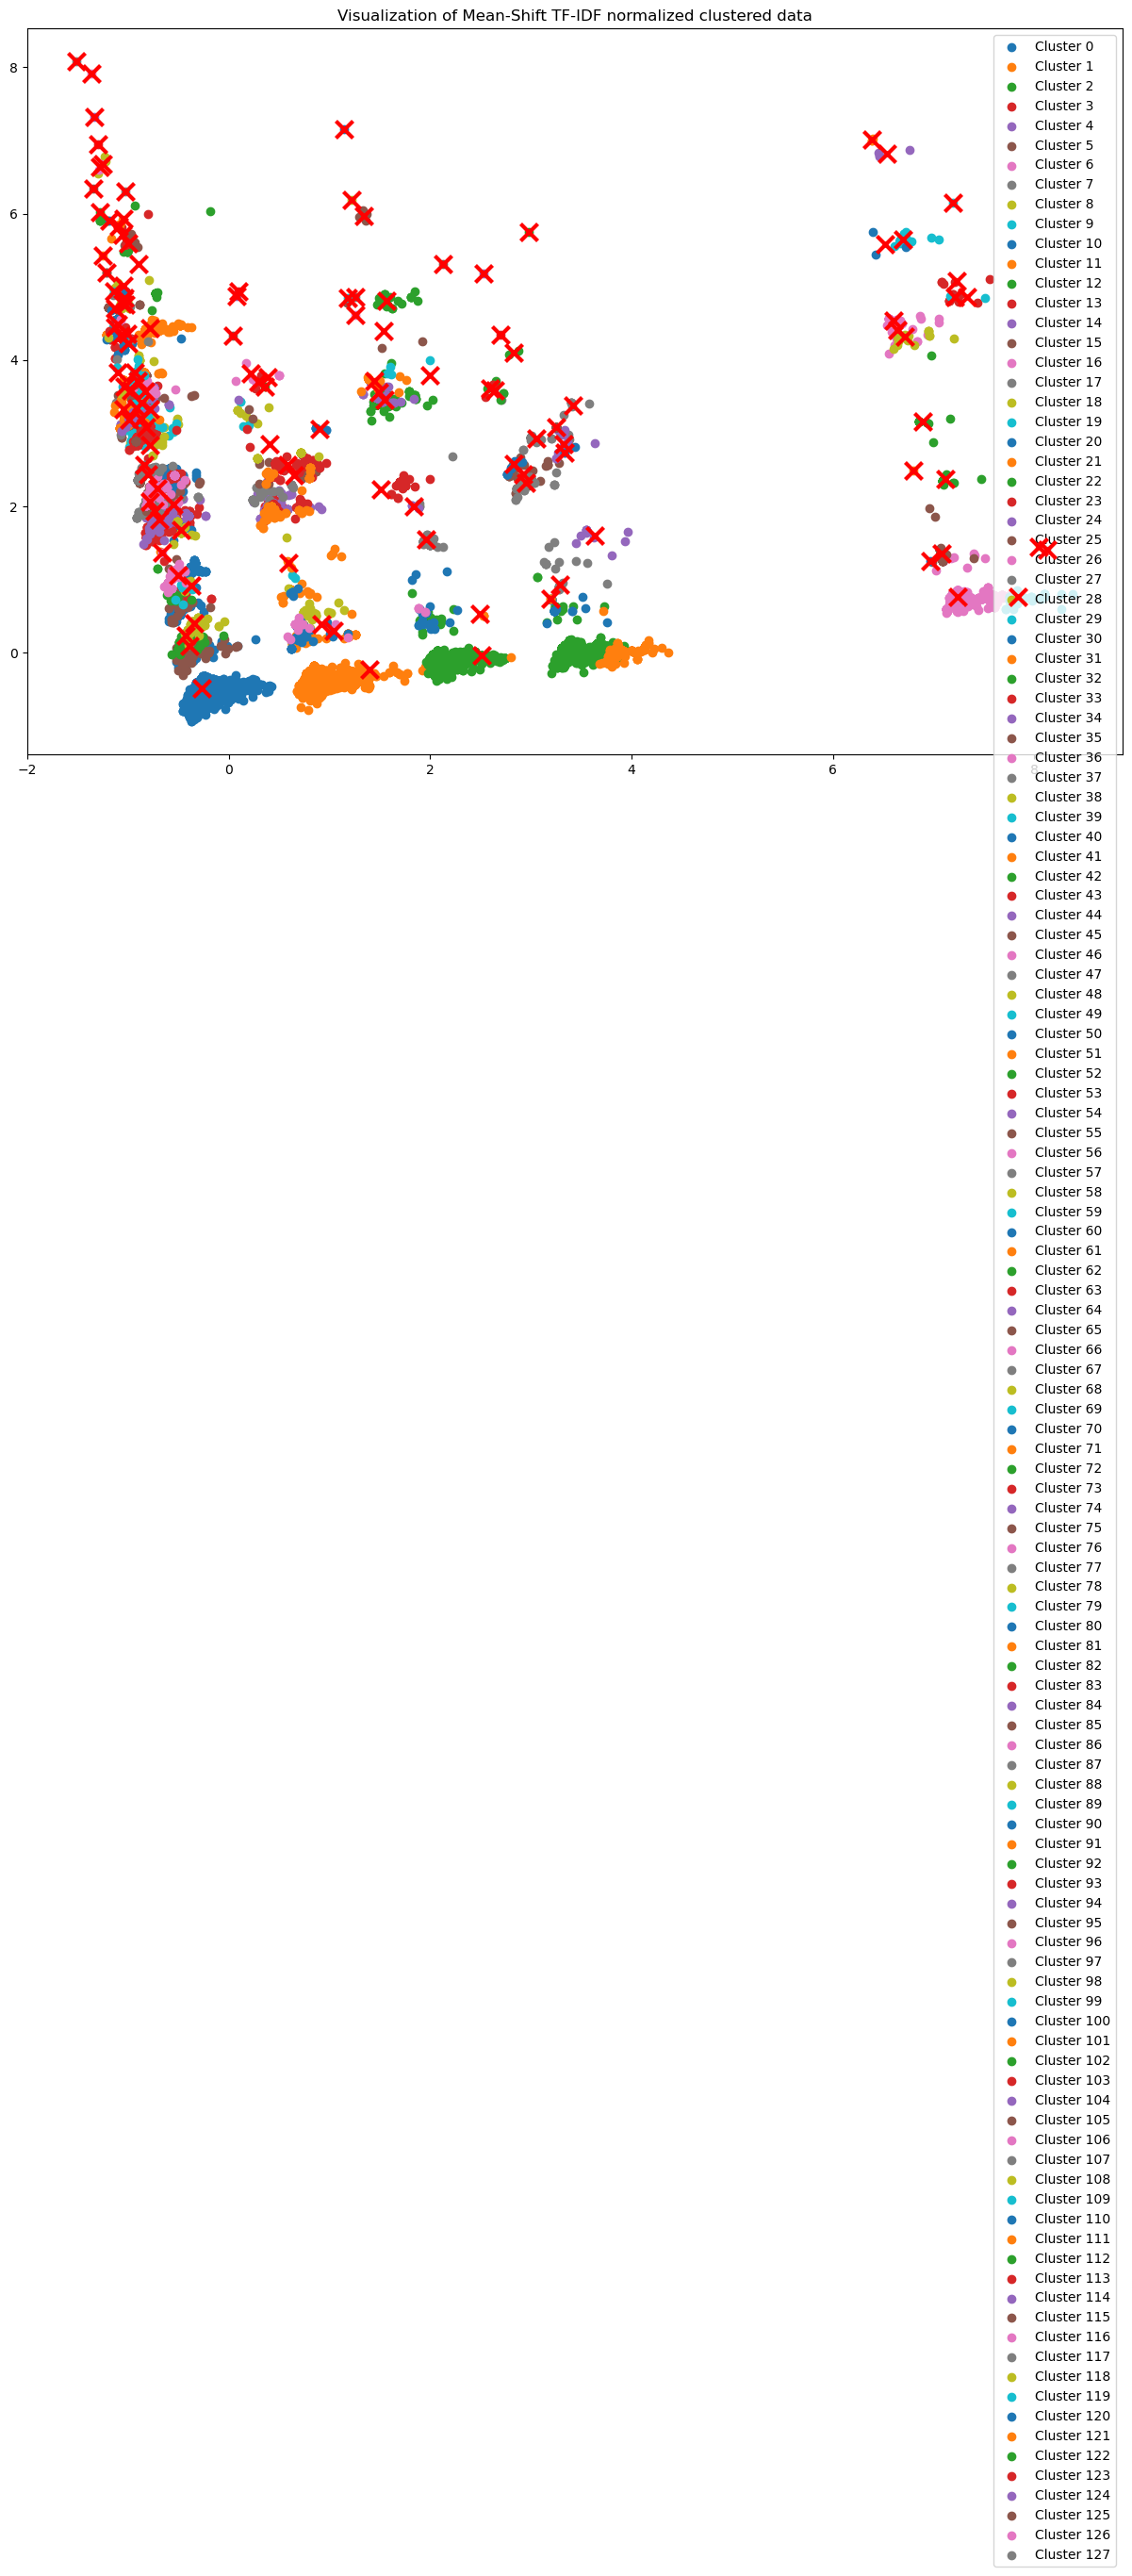

In [30]:
cluster_labels = ms.labels_
cluster_centers = ms.cluster_centers_
plt.figure(figsize=(15,10))
for i in range(len(np.unique(cluster_labels))):
    plt.scatter(transformed_TF_IDF_data[cluster_labels == i, 0], transformed_TF_IDF_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()
plt.scatter(cluster_centers [:, 0], cluster_centers[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of Mean-Shift TF-IDF normalized clustered data')
plt.show()

In [31]:
Meanshift_TF_IDF_silhouette, Meanshift_TF_IDF_davies_bouldin, Meanshift_TF_IDF_calinski_harabasz = evaluate_clustering(ms.labels_, transformed_TF_IDF_data)

print(f'Meanshift TF-IDF Normalized Silhouette score: {Meanshift_TF_IDF_silhouette}')
print(f'Meanshift TF-IDF Normalized Davies-Bouldin Index: {Meanshift_TF_IDF_davies_bouldin}')
print(f'Meanshift TF-IDF Normalized Calinski-Harabasz Index: {Meanshift_TF_IDF_calinski_harabasz}')

Meanshift TF-IDF Normalized Silhouette score: 0.7459103305235634
Meanshift TF-IDF Normalized Davies-Bouldin Index: 0.45515980828595015
Meanshift TF-IDF Normalized Calinski-Harabasz Index: 32866.28736460685
